### Notebook - Player Behaviour Profiling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
from dotenv import load_dotenv
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

This notebook has as goal to quickly explain how I extract the main features from the Riot Games API.
From the user's name tag, we can extract is PUUID and then their matches and all the information with.

### I. Data extraction
In this part, the main goal is to extract the important features from the Riot Game API of a player. In this example we will use my account.
To get access to the API, you'll need an League of Legends account and a API Key that you can get in the API Riot website

##### 1. API Key and PUUID extraction

In [2]:
# API Key setting
load_dotenv("../scripts/api.env")
API_KEY = os.getenv("API_KEY")
headers = {"X-Riot-Token": API_KEY}

# User setting
gameName = "Cotchanadé"
tagLine = "1234"
region = "europe"
user_url = f"https://{region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}"

# PUUID 
user_data = requests.get(user_url, headers=headers).json()
user_puuid = user_data['puuid']


KeyboardInterrupt



##### 2. Features extracting from matches

In [3]:
# Games
match_number = 30 
match_list_url = f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{user_puuid}/ids?start=0&count={match_number}&queue=420"
match_ids = requests.get(match_list_url, headers=headers).json()


metrics = 8 # (KDA, CS/min, Gold/min, Damage/min, Damage taken/min, Vision Score, KP, Winrate  )
stat_data = np.zeros((metrics,match_number))

# Featuring Extraction Algorithm 
for i, match_id in enumerate(match_ids):
    match_url = f"https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}"
    match_data = requests.get(match_url, headers=headers).json()
    time_game = match_data['info']['gameDuration']/60
    
    for p in match_data['info']['participants']:
        if p['puuid'] == user_puuid:
            if p['deaths'] > 0 :
                stat_data[0,i] = (p['kills']+p['assists'])/p['deaths']  # KDA
            else :
                stat_data[0,i] = p['kills']+p['assists']
            
            stat_data[1,i] = (p['totalMinionsKilled']+p['neutralMinionsKilled'])/time_game  # CS/min
            stat_data[2,i] = p['goldEarned']/time_game  # Gold/min
            stat_data[3,i] = p['totalDamageDealtToChampions']/time_game  # Damage/min
            stat_data[4,i] = p['totalDamageTaken']/time_game # Damages taken
            stat_data[5,i] = p['visionScore']  # Vision Score
            stat_data[6,i] = p['challenges']['killParticipation'] # KP
            stat_data[7, i] = int(p['win'])

    time.sleep(1.5)  # Respect the rate limit !

player_stat = []
player_stat.append(user_puuid)
for i in range (metrics):
    player_stat.append(round(np.mean(stat_data[i]),2))


##### 3. Data visualisation

In [33]:
rows = ['Player PUUID', 'KDA', 'CS/min', 'Gold/min', 'Damage/min', 'DamageTaken/min', 'Vision Score', 'Kill Participation', 'Win Rate']
df = pd.DataFrame(player_stat, index=rows, columns=["Valeur"])
df

,Valeur
Player PUUID,qyHoh15wLsj8O_4DK-aEONuWqi36NOk_zM2jWZql641zHH...
KDA,2.93
CS/min,6.81
Gold/min,436.17
Damage/min,765.26
DamageTaken/min,998.82
Vision Score,18.93
Kill Participation,0.43
Win Rate,0.43


##### 4. Data of Emerald players
We generalize our algorithm of data scrapping, in order to get the 8 important metrics for a thousand of player ranked emerald.
The reason we choose emerald players is because it is the median rank.

In [2]:
data_players = pd.read_csv("../data/raw/player_stats.csv")
data_players

,Unnamed: 0,-CyBf7HKKxPCR4qpQ2q9Yc9CYV7cymcyIZYeKPSxzM9GhTTntprBJwsG8EknOHs1KQpmStoz8AZyMA,zyuadBtEmTxyfYAfGqGGtsDwiCtVTcjXay_7nVTolnSTJxm1IqRd6DURgBGzF7ZFJ_R4j-JO4lTOKQ,pLsXOdYonbmQ-wwp6gfRxx2be4hfQGfaTnkhkBW8piL0D5IlwC2e9iX6D4OcQTOupbup-ZEy9x0dHw,ftjtGNQap-mbf1fbtCrNGWLXudjpiZ_9PyRj-2kp8pAkuSAywd5kt6nmAp2fHTu01Xk7cNUmrikuVw,SnI_HRaXDgqOInEjQBfxVTagpXGxOyh-SdJ6gPj5LgETu4OdGyUAxYiBKaemvhmctW7iUCNtBSkMDA,sNVOdHnjnfCoDF6C7ZExzWapZWqGw3GBdOES7Tvg93XFgBacZY5pC0Z1TRcaNmPoexnCaYKIin4liQ,dnqmbC6H4X54xqruhRZ9G2oGTo6W4pY4csShJuyKpuSAI7YtttIFDbAO-Se7ClQthH1lBmU98RFZpg,NGoDPtKMWD3e3lDx6jupVAdzWzIpRM1PgaxezJVBRn423nAGTmPnqa6h5ftRdya7aT7rKrZpxZH29w,KlUvRLrxj8VwdIrWmXlglePZ1IG4emdvgzQtxb_5qwSV5uJwtHyPbfQGI0KlyUEDa1dCjgefHHY7QQ,...,Szq3TmjyYoTpHXlODYorKnDikuR3RmJBsHafHOGqOyhGnB55ZCouYoBaE-zIX8LjdOn6yHdCG-Px8w,O9pSyxIBPujP1WWzN03zlgr9C38Zd10Mv_HlOF0RHanUbKmSAzmJlh__PqvfK717BUzMB24elbKo7A,7geKItv3U7vEHSAnAHUjC6Tbj4tiicpn9sCZnD1moBl4kJfcUKdyoT3S_KPpVOyfV013s9szWxh9jQ,wq9VcpZZDmEfTiZ_P2h_N2c7yWE_ZXt8JJvkprh4k0-zHPbB-7mTtQZl64Pq1wEbuPpKWrnMUuzWuw,LOSkZGYpCIBF8PIZTBreSZGOfBB9x37wvONypoXpA7VXp-IVh4VWFarEfPvoaAvm58Q4JLGTtnfBUA,Ed7GuRQzTrka1M3ZKrsxd0cXyaYwJVbdHvNws2fNK2P0h8B_B6_qnB8MgDJNZRKhVumvj-atHzLvvg,FVaTZewq7TGPVuXRshC38a_jGvJ_fGb3oWEc2HIlbiRvhyeMccchYCse6u84oV6r5hTt35Y3xLPtyA,t33AxNDJpy2oN1QUYBW_lVylQieJncze89WYcaIz9zVEctJ0_LwEidJ-naQ5H5obPrPzxJSaObgDwg,z-cpf1ThbonoI6pXNWBBfxWDXY5p9QISHitkb66mZq36l4LBu3iZbYLJuFcZh1UtCOMMGnktdz4KrQ,_Vx9TPMdmK_D5HBc7KoQFQhqW_oKdiZtJ4-rx-u4xmBrII3C_NUzNQq9PFzlCrV76qxK6XqUae-bQw
0,KDA,5.85,5.73,5.26,2.63,1.40,11.10,2.96,4.49,2.63,...,1.99,3.19,3.78,2.46,1.95,2.18,3.08,3.31,1.96,6.24
1,CS/min,6.98,7.15,6.88,5.98,6.68,6.09,5.99,3.76,6.01,...,6.88,7.40,6.96,6.51,3.29,6.27,6.38,6.66,1.51,6.11
2,Gold/min,446.01,437.79,392.44,369.10,416.58,352.58,412.50,345.78,451.92,...,418.67,476.95,443.98,380.96,333.41,414.37,422.70,426.21,291.37,412.77
3,Damage/min,898.90,1010.07,725.10,637.95,829.12,743.03,838.39,618.46,825.44,...,823.69,1090.58,936.19,623.01,581.37,833.33,1167.25,741.94,447.36,728.34
4,DamageTaken/min,995.83,720.43,519.37,1075.51,949.28,739.18,1119.20,599.94,976.57,...,1011.46,694.67,755.91,1239.29,950.68,1356.69,822.60,1371.09,753.78,638.07
5,Vision Score,21.10,21.40,28.90,14.50,10.50,29.70,22.40,54.60,24.00,...,16.80,18.00,15.40,25.30,40.00,17.40,12.30,16.80,63.60,28.20
6,Kill Participation,0.59,0.58,0.44,0.48,0.40,0.55,0.55,0.51,0.46,...,0.46,0.49,0.45,0.49,0.53,0.40,0.59,0.56,0.55,0.59
7,Win Rate,0.70,0.70,0.60,0.50,0.30,0.70,0.50,0.40,0.70,...,0.30,0.30,0.70,0.40,0.20,0.70,0.40,0.30,0.30,0.40


In [3]:
data_matrix = data_players.to_numpy()
data_matrix = data_matrix[:,1:]

##### 5. Data visualisation

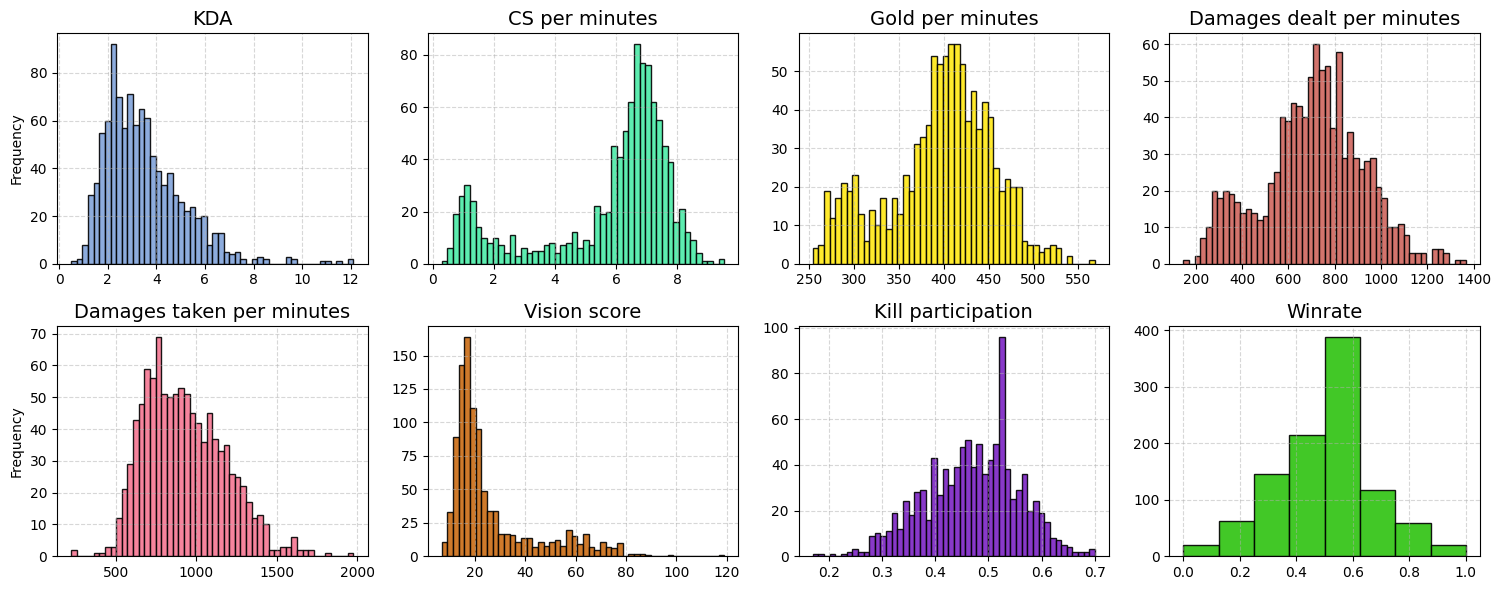

In [4]:
bins = 50
kda_players = data_matrix[0,:]
cs_players = data_matrix[1,:]
gold_players = data_matrix[2,:]
dmg_players = data_matrix[3,:]
dmg_taken_players = data_matrix[4,:]
vision_score_players = data_matrix[5,:]
kp_players = data_matrix[6,:]
winrate_players = data_matrix[7,:]


fig, axs = plt.subplots(2, 4, figsize=(15, 6))  # 1 ligne, 2 colonnes

# KDA
axs[0,0].hist(kda_players, bins=50, color="#81A3DA", edgecolor='black', alpha=0.9)
axs[0,0].set_title("KDA", fontsize=14)
axs[0,0].set_ylabel("Frequency")
axs[0,0].grid(True, linestyle='--', alpha=0.5)

# CS/min
axs[0,1].hist(cs_players, bins=50, color="#4BEBA8", edgecolor='black', alpha=0.9)
axs[0,1].set_title("CS per minutes", fontsize=14)
axs[0,1].grid(True, linestyle='--', alpha=0.5)

# Gold/min
axs[0,2].hist(gold_players, bins=50, color="#FFE815", edgecolor='black', alpha=0.9)
axs[0,2].set_title("Gold per minutes", fontsize=14)
axs[0,2].grid(True, linestyle='--', alpha=0.5)

# Damage
axs[0,3].hist(dmg_players, bins=50, color="#CF655D", edgecolor='black', alpha=0.9)
axs[0,3].set_title("Damages dealt per minutes", fontsize=14)
axs[0,3].grid(True, linestyle='--', alpha=0.5)

# Damage taken
axs[1,0].hist(dmg_taken_players, bins=50, color="#F57792", edgecolor='black', alpha=0.9)
axs[1,0].set_title("Damages taken per minutes", fontsize=14)
axs[1,0].grid(True, linestyle='--', alpha=0.5)
axs[1,0].set_ylabel("Frequency")

# Vision score
axs[1,1].hist(vision_score_players, bins=50, color="#CA6C14", edgecolor='black', alpha=0.9)
axs[1,1].set_title("Vision score", fontsize=14)
axs[1,1].grid(True, linestyle='--', alpha=0.5)

# Kill participation
axs[1,2].hist(kp_players, bins=50, color="#7B23C4", edgecolor='black', alpha=0.9)
axs[1,2].set_title("Kill participation", fontsize=14)
axs[1,2].grid(True, linestyle='--', alpha=0.5)

# Winrate
axs[1,3].hist(winrate_players, bins=8, color="#2DC20F", edgecolor='black', alpha=0.9)
axs[1,3].set_title("Winrate", fontsize=14)
axs[1,3].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### II. Clustering
Now that we have our dataset ready, the second goal is to use machine learning methods or statistical methods in order to make clusters. The clusters will help us to form label for each player in order to identify the profile the most susceptible to win a game. 

We will use one method of clustering ;
- K-means (machine learning method)

The aim is to form clusters with these two methods, compare them, and choose the best

In [11]:
# New dataset
data_nowr= data_matrix.T
data_nowr = data_nowr[:,:7]
scaler = StandardScaler()
data_std = scaler.fit_transform(data_nowr)

#### 1. K-mean 

[7174.999999999997, 4043.673394021896, 3197.3982090275185, 2842.6040985481504, 2600.8612344358567, 2390.8111463194127, 2221.2830641333526, 2090.6679228305807, 1949.0803952648184, 1841.0516603161664, 1774.081421862947, 1714.585924656061, 1650.5486939613265, 1619.8567564676268]


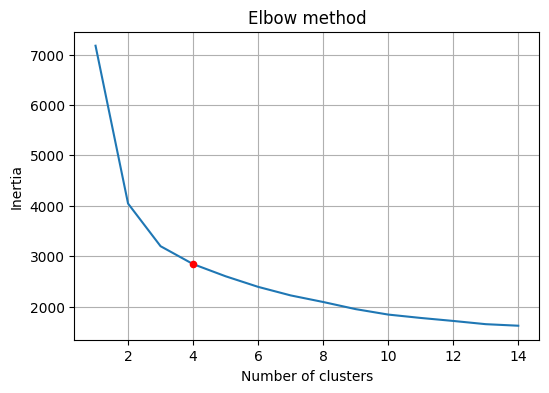

In [12]:
# Find the optimal number of clustering with the elbow method
n_kmeans = 15

inertia_list = []
for i in range(1,n_kmeans):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,n_init=10, random_state=0)
    kmeans.fit(data_std)
    inertia_list.append(kmeans.inertia_)

print(inertia_list)

plt.figure(figsize=(6,4))
plt.scatter(4,inertia_list[3], color='red', s=20,zorder=5)
plt.plot(range(1,n_kmeans),inertia_list)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()

In [43]:
# Ideal number of clusters
n_kmeans_optimal = 4
kmeans = KMeans(n_clusters=n_kmeans_optimal, init='k-means++', max_iter=300,n_init=10, random_state=0)
kmeans.fit(data_std)
kmeans.labels_.shape

(1025,)

#### 2. PCA
In order to correctly visualize the clusters and identify which profiles corresponding to, we need to use PCA to reduct the dimension of the problem. We go from seven variables to three. We are not including winrate in the clustering cause we want to identify which profile is most likely to win

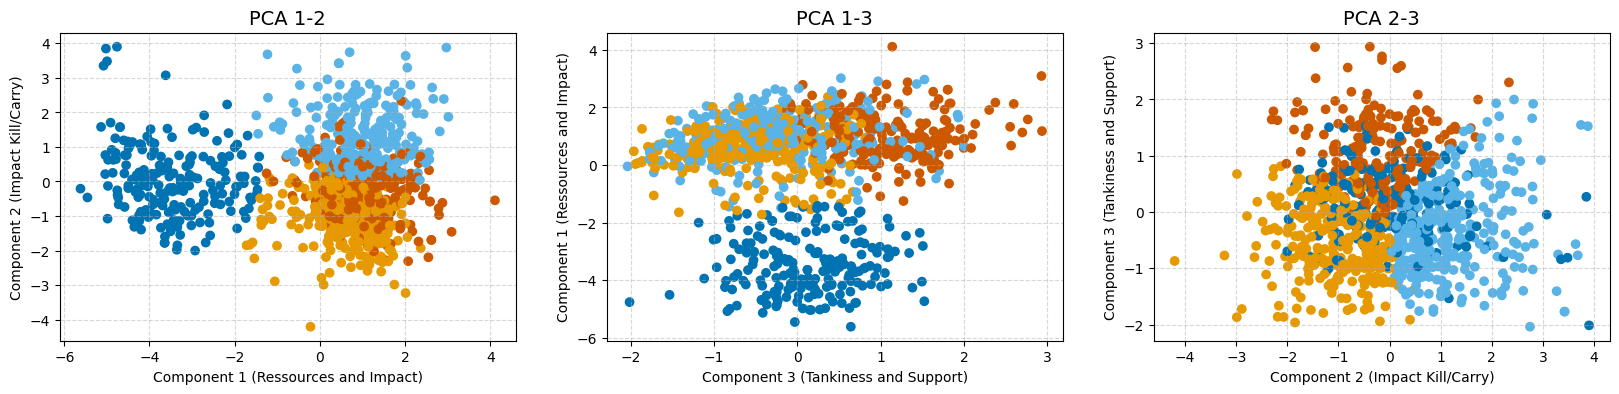

In [59]:
# PCA
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_std)
eigen_values = pca.explained_variance_

# Components' behaviour
loadings = pca.components_
contrib = (loadings**2)/(loadings**2).sum(axis=1)[:, np.newaxis]

label_colors = {
    0: (0.0, 0.45, 0.70, 1.0),  # Blue
    1: (0.80, 0.35, 0.00, 1.0), # Orange
    2: (0.35, 0.70, 0.90, 1.0), # Cyan
    3: (0.90, 0.60, 0.00, 1.0)  # Amber
}

colors = [label_colors[label] for label in labels]
# Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 4))  

# PCA 1
axs[0].scatter(data_pca[:, 0], data_pca[:, 1], c=colors)
axs[0].set_title("PCA 1-2", fontsize=14)
axs[0].set_xlabel("Component 1 (Ressources and Impact)")
axs[0].set_ylabel("Component 2 (Impact Kill/Carry)")
axs[0].grid(True, linestyle='--', alpha=0.5)

axs[1].scatter(data_pca[:, 2], data_pca[:, 0], c=colors)
axs[1].set_title("PCA 1-3", fontsize=14)
axs[1].set_ylabel("Component 1 (Ressources and Impact)")
axs[1].set_xlabel("Component 3 (Tankiness and Support)")
axs[1].grid(True, linestyle='--', alpha=0.5)

axs[2].scatter(data_pca[:, 1], data_pca[:, 2], c=colors)
axs[2].set_title("PCA 2-3", fontsize=14)
axs[2].set_xlabel("Component 2 (Impact Kill/Carry)")
axs[2].set_ylabel("Component 3 (Tankiness and Support)")
axs[2].grid(True, linestyle='--', alpha=0.5)


By studying the PCA of our data, we establish to use 3 components for the PCA in order to represent the data in a subspace.
- PC1 : Represents resources and impact on the game. This axis is mostly explained by CS/min, Gold/min, Damage/min and Vision Score metrics. It captures how well a player accumulates resources and contributes through damage and vision (macro game).
- PC2 : Represents carry potential and impact in fights. This axis highlights players who are involved in kills. It captures the carry potential of a player in duels and teamfights.
- PC3 : Represents tankiness and support. This axis is mostly explained by Damage Taken/min, Kill participation and Vision Score metrics. It captures how well a player can tank and support during the game.

#### 4. Clusters winrate
This little part is dedicated to show which cluster have the best winrate.

In [54]:
labels = kmeans.labels_
print(labels)
cmap = plt.get_cmap("tab10")
print(cmap(labels[0]))

[2 2 2 ... 1 0 2]
(np.float64(0.17254901960784313), np.float64(0.6274509803921569), np.float64(0.17254901960784313), np.float64(1.0))


### III. Machine learning